In [1]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K

import time

import numpy as np
import scipy.optimize as opt
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
from sklearn import metrics
import csv

# my utilities
import cnn_utilities as cn
import uq_utilities_2 as uq

Using TensorFlow backend.


ERROR! Session/line number was not unique in database. History logging moved to new session 3722


In [3]:
## define pinball loss functions
qq = 0.75
def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau*err, (tau-1)*err), axis=-1)

def pinball_loss_lower(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = (1-qq)/2)

def pinball_loss_upper(y_true, y_pred):
    return pinball_loss(y_true, y_pred, tau = 1 - (1-qq)/2)

ERROR! Session/line number was not unique in database. History logging moved to new session 3721


In [5]:
# LOAD trained models and normalization values
# point est model
my_model = models.load_model("../saved_models/train_extant_R0_sampleRate_migrationRate.hdf5")

mean_sd = pd.read_csv("../saved_models/train_extant_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()


# quantile models
q95_model = models.load_model("trained_quantile_CNN/cqr95_train_extant_R0_sampleRate_migrationRate.hdf5",
                              custom_objects = {'pinball_loss_lower': pinball_loss_lower, 
                                                'pinball_loss_upper': pinball_loss_upper})

q25_model = models.load_model("trained_quantile_CNN/cqr25_train_extant_R0_sampleRate_migrationRate.hdf5",
                              custom_objects = {'pinball_loss_lower': pinball_loss_lower, 
                                                'pinball_loss_upper': pinball_loss_upper})







In [6]:
# load trained model and normalization values
train_means = mean_sd[0,:]
train_sd = mean_sd[1,:]
train_aux_priors_means = train_means[3:,]
train_aux_priors_sd = train_sd[3:,]

num_locs = 5
max_tips = 502


In [7]:

############ checking coverage #################


In [8]:
# calibration data set
uq_cal_data = pd.read_csv("data_files/labels_and_preds/uq_calibration_sets_0to40.cblv.csv",
                            header =None, error_bad_lines = False, index_col = 0).to_numpy()
uq_cal_labels = pd.read_table("data_files/labels_and_preds/uq_calibration_sets_0to40_labels.tsv", header = 0).to_numpy()
uq_cal_mutips = pd.read_table("data_files/labels_and_preds/uq_calibration_sets_0to40_numtips_propsamp.txt", header = 0).to_numpy()
uq_cal_mutips = np.column_stack((uq_cal_mutips[:,0], uq_cal_mutips[:,1]/uq_cal_mutips[:,2]))

In [9]:
# get predictions
uq_cal_subsample_prop = uq_cal_data[:,(max_tips-1) * 7]
uq_cal_mu = uq_cal_data[:,(max_tips - 3) * 7]
uq_cal_num_tips = cn.get_num_tips(uq_cal_data)

aux_uq_cal = np.vstack((uq_cal_mu, uq_cal_subsample_prop, uq_cal_num_tips,
                          uq_cal_labels[:,8], uq_cal_labels[:,9])).transpose()

norm_aux_uq_cal = cn.normalize(aux_uq_cal, (train_aux_priors_means, train_aux_priors_sd))

# create input tensors
aux_uq_cal_treeLocation_tensor, aux_uq_cal_prior_tensor = cn.create_data_tensors(data = uq_cal_data, 
                                                                                    mu = norm_aux_uq_cal[:,0],
                                                                                    subsample_prop = norm_aux_uq_cal[:,1],
                                                                                    num_tips = norm_aux_uq_cal[:,2],
                                                                                    tmrca = norm_aux_uq_cal[:,3],
                                                                                    mean_bl = norm_aux_uq_cal[:,4],
                                                                                    num_locs = num_locs,
                                                                                    max_tips = max_tips,
                                                                                    cblv_contains_mu_rho = True)

# PREDICT R0, sample rate, migration rate
uq95_normalized_preds = q95_model.predict([aux_uq_cal_treeLocation_tensor, aux_uq_cal_prior_tensor])
uq25_normalized_preds = q25_model.predict([aux_uq_cal_treeLocation_tensor, aux_uq_cal_prior_tensor])

# reversing normalization
cnn_uq95_preds = np.exp(cn.denormalize(uq95_normalized_preds, train_means[0:3], train_sd[0:3]))

cnn_uq25_preds = np.exp(cn.denormalize(uq25_normalized_preds, train_means[0:3], train_sd[0:3]))


ERROR! Session/line number was not unique in database. History logging moved to new session 3723


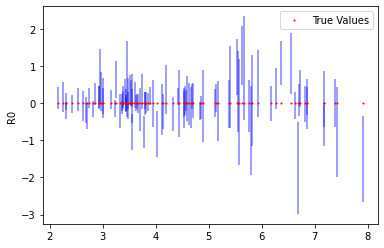

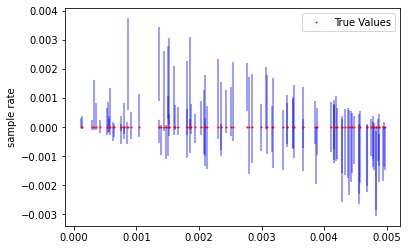

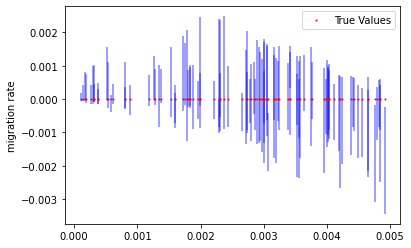

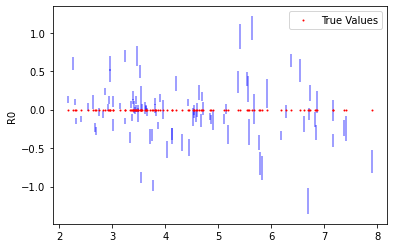

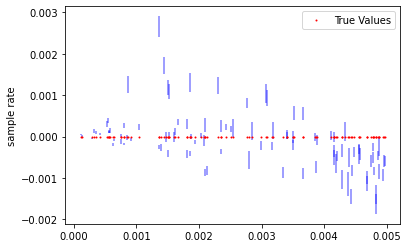

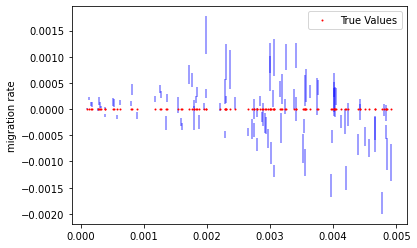

In [16]:
# check some things
# test data plots

# make scatter plots
cn.plot_QI(cnn_uq95_preds[0][0:100], cnn_uq95_preds[1][0:100], uq_cal_labels[0:100,0:3], 
                     param_names = ["R0", "sample rate", "migration rate"])
cn.plot_QI(cnn_uq25_preds[0][0:100], cnn_uq25_preds[1][0:100], uq_cal_labels[0:100,0:3], 
                     param_names = ["R0", "sample rate", "migration rate"])

In [439]:

# randomize the order
rand_idx = np.arange(uq_cal_labels.shape[0])
np.random.shuffle(rand_idx)
cnn_uq_cal_log_preds = cnn_uq_cal_log_preds[rand_idx,:]
uq_cal_labels = uq_cal_labels[rand_idx,:]


In [440]:
# split calibration prediction dat for conformal prediction interval estimation and validation
uq_num_val = 5000

# for measuring resulting coverage
cal_val_preds = cnn_uq_cal_log_preds[0:uq_num_val,:]
cal_val_labels = uq_cal_labels[0:uq_num_val,:]

# for creating UQ
cal_preds = cnn_uq_cal_log_preds[uq_num_val:,:]
cal_labels = uq_cal_labels[uq_num_val:,:]

In [455]:
im.reload(uq)

<module 'uq_utilities_2' from 'C:\\Users\\ammon_work\\Desktop\\RESEARCH_PROJECTS\\phylogeo_epi_cnn\\neural_network_dev\\uq_and_adequacy\\uq_utilities_2.py'>

In [ ]:
# make dictionaries containing interval estimating functions
# the keys should be the quantile number
# the values should be (lower_q_fun, upper_q_fun)

nn = cal_preds.shape[0]

R0_cpi_fun = {}
delta_cpi_fun = {}
m_cpi_fun = {}

inner_q = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
# inner_q = [0.85, 0.9, 0.95]
grid_points = 50
for q in inner_q:
    start_time = time.time()

    m, lower_q, upper_q = uq.get_CPI(cal_preds[0:nn,[0,3,4]],
                                                   np.log(cal_labels[0:nn,0]), 
                                                   frac=0.05, inner_quantile=q, grid_points = grid_points)
    R0_cpi_fun[q] = (lower_q, upper_q)
    
    m, lower_q, upper_q = uq.get_CPI(cal_preds[0:nn,[1,3,4]],
                                               np.log(cal_labels[0:nn,1]), 
                                               frac=0.05, inner_quantile=q, grid_points = grid_points)
    delta_cpi_fun[q] = (lower_q, upper_q)
    
    m, lower_q, upper_q = uq.get_CPI(cal_preds[0:nn,[2,3,4]],
                                               np.log(cal_labels[0:nn,2]), 
                                               frac=0.05, inner_quantile=q, grid_points = grid_points)
    m_cpi_fun[q] = (lower_q, upper_q)
    
    print(str(q) + " is done.   time = " + str(time.time() - start_time))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ammon_work\Anaconda3\envs\tf-keras-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-456-b6c3c9a6a91a>", line 19, in <module>
    frac=0.05, inner_quantile=q, grid_points = grid_points)
  File "C:\Users\ammon_work\Desktop\RESEARCH_PROJECTS\phylogeo_epi_cnn\neural_network_dev\uq_and_adequacy\uq_utilities_2.py", line 106, in get_CPI
    local_lower_q[i, j, k] = point[0] + np.quantile(residuals, rlq)
  File "<__array_function__ internals>", line 6, in quantile
  File "C:\Users\ammon_work\Anaconda3\envs\tf-keras-gpu\lib\site-packages\numpy\lib\function_base.py", line 3845, in quantile
    a, q, axis, out, overwrite_input, interpolation, keepdims)
  File "C:\Users\ammon_work\Anaconda3\envs\tf-keras-gpu\lib\site-packages\numpy\lib\function_base.py", line 3853, in _quantile_unchecked
    interpolation=interpolation)
  File "C:\Users\amm

In [450]:
# check calibration data
i=0
uq_cal_R0_coverage = uq.make_coverage_set(None, None, 
                                   cal_preds[:,[i,3,4]], cal_labels[:,i], quantiles = inner_q, q_fun = R0_cpi_fun)
i=1
uq_cal_delta_coverage = uq.make_coverage_set(None, None,  
                                   cal_preds[:,[i,3,4]], cal_labels[:,i], quantiles = inner_q, q_fun = delta_cpi_fun)
i=2
uq_cal_m_coverage = uq.make_coverage_set(None, None,  
                                   cal_preds[:,[i,3,4]], cal_labels[:,i], quantiles = inner_q, q_fun = m_cpi_fun)

0.05 finished: 5.056236700780221
0.1 finished: 9.976142005729603
0.25 finished: 25.009441870319364
0.5 finished: 50.13126502639118
0.75 finished: 75.39678884293333
0.9 finished: 90.33060363488978
0.95 finished: 94.96955572545804
0.05 finished: 5.077423336618797
0.1 finished: 10.129975405079266
0.25 finished: 25.29407971702024
0.5 finished: 50.73001777835094
0.75 finished: 76.32623734559087
0.9 finished: 91.01594524636373
0.95 finished: 95.5029062537422
0.05 finished: 5.012021112943192
0.1 finished: 9.996407483488241
0.25 finished: 25.134719369190943
0.5 finished: 50.5743420628414
0.75 finished: 76.16871931392146
0.9 finished: 91.04357998876186
0.95 finished: 95.62357796221409


In [451]:
# check cal hold-out validation data
i=0
uq_cal_R0_coverage = uq.make_coverage_set(None, None, 
                                   cal_val_preds[:,[i,3,4]], cal_val_labels[:,i], quantiles = inner_q, q_fun = R0_cpi_fun)
i=1
uq_cal_delta_coverage = uq.make_coverage_set(None, None,  
                                   cal_val_preds[:,[i,3,4]], cal_val_labels[:,i], quantiles = inner_q, q_fun = delta_cpi_fun)
i=2
uq_cal_m_coverage = uq.make_coverage_set(None, None,  
                                   cal_val_preds[:,[i,3,4]], cal_val_labels[:,i], quantiles = inner_q, q_fun = m_cpi_fun)

0.05 finished: 5.06
0.1 finished: 9.86
0.25 finished: 25.44
0.5 finished: 50.44
0.75 finished: 74.4
0.9 finished: 89.98
0.95 finished: 95.39999999999999
0.05 finished: 4.74
0.1 finished: 9.58
0.25 finished: 24.36
0.5 finished: 50.22
0.75 finished: 76.62
0.9 finished: 91.03999999999999
0.95 finished: 96.12
0.05 finished: 5.1
0.1 finished: 10.22
0.25 finished: 25.52
0.5 finished: 50.2
0.75 finished: 75.98
0.9 finished: 90.53999999999999
0.95 finished: 95.36


In [452]:
# write to file
df_caltest_coverage = pd.DataFrame(np.transpose(np.vstack((uq_cal_R0_coverage, uq_cal_delta_coverage, uq_cal_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_caltest_coverage.to_csv('../data_files/caltest_coverage.tsv', sep = "\t", index = True)

df_caltest_labels = pd.DataFrame(cal_val_labels[:,0:3], columns = ['R0', 'sample_rate', 'migration_rate'])
df_caltest_labels.to_csv("output/caltest_labels.tsv", sep = "\t", index = False)

# write 95% quantiles to file
caltest_R0_95_q = np.array([R0_cpi_fun[0.95][0](cal_val_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cal_val_preds[:,[0,3,4]])]).transpose()
caltest_delta_95_q = np.array([delta_cpi_fun[0.95][0](cal_val_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cal_val_preds[:,[1,3,4]])]).transpose()
caltest_m_95_q = np.array([m_cpi_fun[0.95][0](cal_val_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cal_val_preds[:,[2,3,4]])]).transpose()

df_caltest_95q = pd.DataFrame(np.hstack((caltest_R0_95_q, caltest_delta_95_q, caltest_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_caltest_95q.to_csv('output/caltest_95q.tsv', sep = "\t", index = False)

In [453]:
# coverage experiment 0 (true model dataset)
im.reload(uq)

### coverage of CI for test dataset
cnn_phylocomp_preds = pd.read_table("data_files/labels_and_preds/extant_cnn_preds.tsv", header = 0).to_numpy()
cnn_phylocomp_labels = pd.read_table("data_files/labels_and_preds/extant_labels.tsv", header = 0).to_numpy()
cnn_phylocomp_mutips = pd.read_table("data_files/labels_and_preds/extant_phylocomp_param_values_numtips_propsamp.txt", header = 0).to_numpy()

cnn_phylocomp_preds = np.column_stack((np.log(cnn_phylocomp_preds[:,0:3]), cnn_phylocomp_mutips[:,0], cnn_phylocomp_mutips[:,1]/cnn_phylocomp_mutips[:,2]))

# phylocomp true model

# compute coverages
i=0
R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_phylocomp_preds[:,[i,3,4]], cnn_phylocomp_labels[:,i], quantiles = inner_q, q_fun = R0_cpi_fun)
i=1
delta_coverage = uq.make_coverage_set(None, None,  
                                   cnn_phylocomp_preds[:,[i,3,4]], cnn_phylocomp_labels[:,i], quantiles = inner_q, q_fun = delta_cpi_fun)
i=2
m_coverage = uq.make_coverage_set(None, None,  
                                   cnn_phylocomp_preds[:,[i,3,4]], cnn_phylocomp_labels[:,i], quantiles = inner_q, q_fun = m_cpi_fun)

0.05 finished: 7.246376811594203
0.1 finished: 8.695652173913043
0.25 finished: 28.26086956521739
0.5 finished: 59.42028985507246
0.75 finished: 82.6086956521739
0.9 finished: 92.02898550724638
0.95 finished: 96.37681159420289
0.05 finished: 6.521739130434782
0.1 finished: 10.144927536231885
0.25 finished: 31.15942028985507
0.5 finished: 60.14492753623188
0.75 finished: 79.71014492753623
0.9 finished: 92.7536231884058
0.95 finished: 97.10144927536231
0.05 finished: 5.797101449275362
0.1 finished: 10.869565217391305
0.25 finished: 25.36231884057971
0.5 finished: 48.55072463768116
0.75 finished: 73.18840579710145
0.9 finished: 92.7536231884058
0.95 finished: 97.10144927536231


In [454]:
# write to file
df_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((R0_coverage, delta_coverage, m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_cnn_coverage.to_csv('../data_files/fuck_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
phylocomp_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_phylocomp_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_phylocomp_preds[:,[0,3,4]])]).transpose()
phylocomp_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_phylocomp_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_phylocomp_preds[:,[1,3,4]])]).transpose()
phylocomp_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_phylocomp_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_phylocomp_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((phylocomp_R0_95_q, phylocomp_delta_95_q, phylocomp_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/fuck_phylocomp_cnn_95q.tsv', sep = "\t", index = False)

In [323]:
# measure coverage of predictions on out-of-model test data (misspecified)


In [418]:
# make coverage sets for R0 misspecification experiments
cnn_miss_r0_preds = pd.read_table("../output/misspec_R0_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_r0_labels = pd.read_table("../output/misspec_R0_labels.tsv", header = 0).to_numpy()
cnn_miss_r0_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_R0_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_r0_preds = np.column_stack((np.log(cnn_miss_r0_preds[:,0:3]), cnn_miss_r0_mutips[:,0], 
                                       cnn_miss_r0_mutips[:,1]/cnn_miss_r0_mutips[:,2]))


i=0
missR0_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,[i,3,4]], cnn_miss_r0_labels[:,i], q_fun = R0_cpi_fun)
i=1
missR0_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,[i,3,4]], cnn_miss_r0_labels[:,i], q_fun = delta_cpi_fun)
i=2
missR0_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,[i,3,4]], cnn_miss_r0_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 0.0
0.1 finished: 0.0
0.25 finished: 0.0
0.5 finished: 8.60215053763441
0.75 finished: 19.35483870967742
0.9 finished: 33.33333333333333
0.95 finished: 41.935483870967744
0.05 finished: 4.301075268817205
0.1 finished: 8.60215053763441
0.25 finished: 24.731182795698924
0.5 finished: 43.01075268817204
0.75 finished: 73.11827956989248
0.9 finished: 86.02150537634408
0.95 finished: 91.39784946236558
0.05 finished: 3.225806451612903
0.1 finished: 8.60215053763441
0.25 finished: 13.978494623655912
0.5 finished: 25.806451612903224
0.75 finished: 50.53763440860215
0.9 finished: 75.26881720430107
0.95 finished: 79.56989247311827


In [307]:
df_missR0_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missR0_R0_coverage, missR0_delta_coverage, missR0_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missR0_cnn_coverage.to_csv('../data_files/missR0_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missR0_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_r0_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_r0_preds[:,[0,3,4]])]).transpose()
missR0_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_r0_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_r0_preds[:,[1,3,4]])]).transpose()
missR0_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_r0_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_r0_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missR0_R0_95_q, missR0_delta_95_q, missR0_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missR0_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 0.0
0.1 finished: 0.0
0.25 finished: 1.0752688172043012
0.5 finished: 7.526881720430108
0.75 finished: 15.053763440860216
0.9 finished: 24.731182795698924
0.95 finished: 35.483870967741936
0.05 finished: 5.376344086021505
0.1 finished: 6.451612903225806
0.25 finished: 22.58064516129032
0.5 finished: 37.634408602150536
0.75 finished: 65.59139784946237
0.9 finished: 80.64516129032258
0.95 finished: 87.09677419354838
0.05 finished: 2.1505376344086025
0.1 finished: 5.376344086021505
0.25 finished: 12.903225806451612
0.5 finished: 23.655913978494624
0.75 finished: 45.16129032258064
0.9 finished: 61.29032258064516
0.95 finished: 73.11827956989248


In [320]:
# make coverage sets for delta misspecification experiments

cnn_miss_delta_preds = pd.read_table("../output/misspec_delta_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_delta_labels = pd.read_table("../output/misspec_delta_labels.tsv", header = 0).to_numpy()
cnn_miss_delta_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_delta_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_delta_preds = np.column_stack((np.log(cnn_miss_delta_preds[:,0:3]), cnn_miss_delta_mutips[:,0], 
                                       cnn_miss_delta_mutips[:,1]/cnn_miss_delta_mutips[:,2]))

i=0
missDelta_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,[i,3,4]], cnn_miss_delta_labels[:,i], q_fun = R0_cpi_fun)
i=1
missDelta_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,[i,3,4]], cnn_miss_delta_labels[:,i], q_fun = delta_cpi_fun)
i=2
missDelta_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,[i,3,4]], cnn_miss_delta_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 8.47457627118644
0.1 finished: 12.711864406779661
0.25 finished: 28.8135593220339
0.5 finished: 44.06779661016949
0.75 finished: 64.40677966101694
0.9 finished: 83.05084745762711
0.95 finished: 89.83050847457628
0.05 finished: 0.0
0.1 finished: 0.847457627118644
0.25 finished: 5.932203389830509
0.5 finished: 23.728813559322035
0.75 finished: 39.83050847457627
0.9 finished: 50.847457627118644
0.95 finished: 61.016949152542374
0.05 finished: 3.389830508474576
0.1 finished: 5.084745762711865
0.25 finished: 12.711864406779661
0.5 finished: 32.20338983050847
0.75 finished: 48.30508474576271
0.9 finished: 67.79661016949152
0.95 finished: 77.96610169491525


In [309]:
df_missDelta_missR0_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missDelta_R0_coverage, missDelta_delta_coverage, missDelta_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missDelta_missR0_cnn_coverage.to_csv('../data_files/missDelta_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missDeltaR0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_delta_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_delta_preds[:,[0,3,4]])]).transpose()
missDeltadelta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_delta_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_delta_preds[:,[1,3,4]])]).transpose()
missDeltam_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_delta_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_delta_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missDeltaR0_95_q, missDeltadelta_95_q, missDeltam_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missDeltacnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 8.47457627118644
0.1 finished: 12.711864406779661
0.25 finished: 28.8135593220339
0.5 finished: 44.06779661016949
0.75 finished: 64.40677966101694
0.9 finished: 82.20338983050848
0.95 finished: 88.98305084745762
0.05 finished: 0.0
0.1 finished: 0.847457627118644
0.25 finished: 5.084745762711865
0.5 finished: 23.728813559322035
0.75 finished: 39.83050847457627
0.9 finished: 50.847457627118644
0.95 finished: 60.16949152542372
0.05 finished: 3.389830508474576
0.1 finished: 5.084745762711865
0.25 finished: 12.711864406779661
0.5 finished: 32.20338983050847
0.75 finished: 49.152542372881356
0.9 finished: 66.94915254237289
0.95 finished: 77.96610169491525


In [ ]:
# make coverage sets for m misspecification experiments
cnn_miss_m_preds = pd.read_table("../output/misspec_migration_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_m_labels = pd.read_table("../output/misspec_migration_labels.tsv", header = 0).to_numpy()
cnn_miss_m_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_m_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_m_preds = np.column_stack((np.log(cnn_miss_m_preds[:,0:3]), cnn_miss_m_mutips[:,0], 
                                       cnn_miss_m_mutips[:,1]/cnn_miss_m_mutips[:,2]))

i=0
missM_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,[i,3,4]], cnn_miss_m_labels[:,i], q_fun = R0_cpi_fun)
i=1
missM_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,[i,3,4]], cnn_miss_m_labels[:,i], q_fun = delta_cpi_fun)
i=2
missM_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,[i,3,4]], cnn_miss_m_labels[:,i], q_fun = m_cpi_fun)

In [310]:
df_missM_missR0_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missM_R0_coverage, missM_delta_coverage, missM_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missM_missR0_cnn_coverage.to_csv('../data_files/missM_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missM_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_m_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_m_preds[:,[0,3,4]])]).transpose()
missM_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_m_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_m_preds[:,[1,3,4]])]).transpose()
missM_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_m_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_m_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missM_R0_95_q, missM_delta_95_q, missM_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missM_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 3.3333333333333335
0.1 finished: 8.88888888888889
0.25 finished: 27.77777777777778
0.5 finished: 48.888888888888886
0.75 finished: 73.33333333333333
0.9 finished: 90.0
0.95 finished: 94.44444444444444
0.05 finished: 3.3333333333333335
0.1 finished: 10.0
0.25 finished: 23.333333333333332
0.5 finished: 47.77777777777778
0.75 finished: 67.77777777777779
0.9 finished: 92.22222222222223
0.95 finished: 96.66666666666667
0.05 finished: 4.444444444444445
0.1 finished: 7.777777777777778
0.25 finished: 15.555555555555555
0.5 finished: 27.77777777777778
0.75 finished: 54.44444444444444
0.9 finished: 66.66666666666666
0.95 finished: 74.44444444444444


In [ ]:
# make coverage sets for numloc misspecification experiments

cnn_miss_loc_preds = pd.read_table("../output/misspec_numloc_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_loc_labels = pd.read_table("../output/misspec_numloc_labels.tsv", header = 0).to_numpy()
cnn_miss_loc_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_numloc_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_loc_preds = np.column_stack((np.log(cnn_miss_loc_preds[:,0:3]), cnn_miss_loc_mutips[:,0], 
                                       cnn_miss_loc_mutips[:,1]/cnn_miss_loc_mutips[:,2]))

i=0
missNumLoc_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,[i,3,4]], cnn_miss_loc_labels[:,i], q_fun = R0_cpi_fun)
i=1
missNumLoc_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,[i,3,4]], cnn_miss_loc_labels[:,i], q_fun = delta_cpi_fun)
i=2
missNumLoc_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,[i,3,4]], cnn_miss_loc_labels[:,i], q_fun = m_cpi_fun)

In [311]:
df_missNumLoc_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missNumLoc_R0_coverage, missNumLoc_delta_coverage, missNumLoc_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missNumLoc_cnn_coverage.to_csv('../data_files/missNumLoc_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missNumLoc_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_loc_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_loc_preds[:,[0,3,4]])]).transpose()
missNumLoc_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_loc_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_loc_preds[:,[1,3,4]])]).transpose()
missNumLoc_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_loc_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_loc_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missNumLoc_R0_95_q, missNumLoc_delta_95_q, missNumLoc_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missNumLoc_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 4.201680672268908
0.1 finished: 6.722689075630252
0.25 finished: 23.52941176470588
0.5 finished: 47.05882352941176
0.75 finished: 68.90756302521008
0.9 finished: 86.5546218487395
0.95 finished: 92.43697478991596
0.05 finished: 2.5210084033613445
0.1 finished: 6.722689075630252
0.25 finished: 16.80672268907563
0.5 finished: 43.69747899159664
0.75 finished: 70.58823529411765
0.9 finished: 86.5546218487395
0.95 finished: 93.27731092436974
0.05 finished: 3.361344537815126
0.1 finished: 5.042016806722689
0.25 finished: 15.966386554621847
0.5 finished: 34.45378151260504
0.75 finished: 57.98319327731093
0.9 finished: 69.74789915966386
0.95 finished: 75.63025210084034
ERROR! Session/line number was not unique in database. History logging moved to new session 3573


In [331]:
# make coverage sets for tree misspecification experiments

cnn_miss_tree_preds = pd.read_table("../output/misspec_tree_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_tree_labels = pd.read_table("../output/misspec_tree_labels.tsv", header = 0).to_numpy()
cnn_miss_tree_mutips = pd.read_table("data_files/labels_and_preds/extant_misspec_tree_param_values_numtips_propsamp.txt", 
                                     header = 0).to_numpy()

cnn_miss_tree_preds = np.column_stack((np.log(cnn_miss_tree_preds[:,0:3]), cnn_miss_tree_mutips[:,0], 
                                       cnn_miss_tree_mutips[:,1]/cnn_miss_tree_mutips[:,2]))

i=0
missTree_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,[i,3,4]], cnn_miss_tree_labels[:,i], q_fun = R0_cpi_fun)
i=1
missTree_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,[i,3,4]], cnn_miss_tree_labels[:,i], q_fun = delta_cpi_fun)
i=2
missTree_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,[i,3,4]], cnn_miss_tree_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 2.9702970297029703
0.1 finished: 4.9504950495049505
0.25 finished: 18.81188118811881
0.5 finished: 31.683168316831683
0.75 finished: 54.45544554455446
0.9 finished: 70.29702970297029
0.95 finished: 77.22772277227723
0.05 finished: 3.9603960396039604
0.1 finished: 5.9405940594059405
0.25 finished: 16.831683168316832
0.5 finished: 35.64356435643564
0.75 finished: 53.46534653465347
0.9 finished: 68.31683168316832
0.95 finished: 77.22772277227723
0.05 finished: 5.9405940594059405
0.1 finished: 9.900990099009901
0.25 finished: 21.782178217821784
0.5 finished: 39.603960396039604
0.75 finished: 66.33663366336634
0.9 finished: 86.13861386138613
0.95 finished: 91.0891089108911


In [313]:
df_missTree_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((missTree_R0_coverage, missTree_delta_coverage, missTree_m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_missTree_cnn_coverage.to_csv('../data_files/missTree_cnn_coverage.tsv', sep = "\t", index = True)

# write 95% quantiles to file
missTree_R0_95_q = np.array([R0_cpi_fun[0.95][0](cnn_miss_tree_preds[:,[0,3,4]]), R0_cpi_fun[0.95][1](cnn_miss_tree_preds[:,[0,3,4]])]).transpose()
missTree_delta_95_q = np.array([delta_cpi_fun[0.95][0](cnn_miss_tree_preds[:,[1,3,4]]), delta_cpi_fun[0.95][1](cnn_miss_tree_preds[:,[1,3,4]])]).transpose()
missTree_m_95_q = np.array([m_cpi_fun[0.95][0](cnn_miss_tree_preds[:,[2,3,4]]), m_cpi_fun[0.95][1](cnn_miss_tree_preds[:,[2,3,4]])]).transpose()

df_cnn_95q = pd.DataFrame(np.hstack((missTree_R0_95_q, missTree_delta_95_q, missTree_m_95_q)),
                         columns = ["R0_lq", "R0_uq", "delta_lq", "delta_uq", "m_lq", "m_uq"])
df_cnn_95q.to_csv('output/missTree_cnn_95q.tsv', sep = "\t", index = False)

0.05 finished: 2.9702970297029703
0.1 finished: 2.9702970297029703
0.25 finished: 20.792079207920793
0.5 finished: 31.683168316831683
0.75 finished: 54.45544554455446
0.9 finished: 72.27722772277228
0.95 finished: 78.21782178217822
0.05 finished: 4.9504950495049505
0.1 finished: 5.9405940594059405
0.25 finished: 16.831683168316832
0.5 finished: 34.65346534653465
0.75 finished: 53.46534653465347
0.9 finished: 69.3069306930693
0.95 finished: 79.20792079207921
0.05 finished: 5.9405940594059405
0.1 finished: 9.900990099009901
0.25 finished: 19.801980198019802
0.5 finished: 38.613861386138616
0.75 finished: 67.32673267326733
0.9 finished: 87.12871287128714
0.95 finished: 92.07920792079209
